# Train and Predict
Train and evaluate model
- <a href='#1'>1. lightgbm</a> 
- <a href='#2'>2. task2</a> 
- <a href='#3'>3. ensemble</a>

In [1]:
# ! pip install zipfile -i http://mirrors.aliyun.com/pypi/simple/ --trusted-host mirrors.aliyun.com
%load_ext autoreload
%autoreload 1
import sys
import os
import gc
from time import time
from datetime import timedelta, datetime
import base64
import warnings

import pandas as pd
from IPython.core.display import display, HTML
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import lightgbm as lgb
from sklearn import metrics

sys.path.append('../')
import conf
from mlpipeline import (
    feature_engineering,
    train,
    predict,
)
from utils import (
    check_columns,
    check_nan_value,
    correct_column_type,
    load_model,
    plot_dist_of_cols,
)

In [2]:
# global settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns',1000)
pd.set_option('display.width',100)
sns.set(rc={'figure.figsize':(20,10)})
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
warnings.simplefilter('ignore', np.RankWarning)

In [3]:
# global variables
drop_cols = []

In [4]:
# functions
def __dummy():
    pass

### <a id='1'> 1.lightgbm</a>

In [5]:
! du -sh ../data/*

67M	../data/chunk_data_for_test.h5
4.2G	../data/data_2017_all.h5
4.7G	../data/data_2017_new_all.h5
2.3G	../data/data_2017_tag_flag.h5
2.5G	../data/data_2017_tag_flag_raw.h5
12G	../data/data_2017_to_2018_all.h5
20M	../data/data_201808_test.h5
41M	../data/data_201808_test_all.h5
46M	../data/data_201808_test_b.h5
24M	../data/data_201808_test_raw.h5
6.9G	../data/data_2018_all.h5
7.9G	../data/data_2018_new_all.h5
2.5G	../data/data_2018_semifinals.h5
9.1G	../data/data_2018_semifinals_all.h5
3.9G	../data/data_2018_tag_flag.h5
4.2G	../data/data_2018_tag_flag_raw.h5
36K	../data/disk_sample_fault_tag.csv
8.0K	../data/disk_sample_fault_tag_201808.csv
4.0K	../data/disk_sample_fault_tag_201808.zip
1.2G	../data/disk_sample_smart_log_201707.csv
228M	../data/disk_sample_smart_log_201707_norm.csv
233M	../data/disk_sample_smart_log_201707_raw.csv
2.2G	../data/disk_sample_smart_log_201708.csv
446M	../data/disk_sample_smart_log_201708_norm.csv
460M	../data/disk_sample_smart_log_201708_raw.csv
2.2G	../data

In [ ]:
# feature engineering
params = {
    'filename':'data_2018_semifinals_all.h5', # file we want to load for feature engineering
    'fe_save_filename':'train_fe_df_01_01_round_2.feather',  # naming the train fe by the start date of train
    'clip_start_date': '2018-01-01', # start date of data for doing feature engineering e.g. 2018-02-01
    'clip_end_date': '2018-07-31',  # end date of data for doing feature engineering e.g. 2018-06-30
    'use_model_id': None,  # 1,2 and None
    'is_train':True,
    'pred_start_date':None,  # None, 2018-09-01
    'pred_end_date':None,  # None, 2018-09-30
#     'use_retag':False,
#     'num_tag':10,
    'num_processes': 20,
}

fe_df = feature_engineering(**params)

2020-03-28 06:19:43,004 - mlpipeline.feature_engineering - INFO - feature_engineering开始
2020-03-28 06:19:43,006 - mlpipeline.feature_engineering - INFO - 训练数据特征工程: True，数据集截断起始日期：2018-01-01, 数据集截断结束日期：2018-07-31
2020-03-28 06:19:43,007 - mlpipeline.feature_engineering - INFO - _load_data_into_dataframe开始
2020-03-28 06:19:43,008 - mlpipeline.feature_engineering - INFO - 加载数据集: ../data/data_2018_semifinals_all.h5
2020-03-28 06:23:06,389 - mlpipeline.feature_engineering - INFO - 使用的cols: Index(['smart_1_normalized', 'smart_3_normalized', 'smart_7_normalized', 'smart_184_normalized',
       'smart_9_normalized', 'smart_187_normalized', 'smart_188_normalized',
       'smart_189_normalized', 'smart_191_normalized', 'smart_193_normalized',
       'smart_195_normalized', 'smart_4raw', 'smart_5raw', 'smart_9raw', 'smart_12raw',
       'smart_192raw', 'smart_194raw', 'smart_197raw', 'smart_198raw', 'smart_199raw', 'dt',
       'serial_number', 'model', 'tag', 'flag'],
      dtype='object')
2020-

2020-03-27 17:09:45,249 - mlpipeline.train - INFO - train开始
2020-03-27 17:09:45,251 - mlpipeline.train - INFO - 当前模式:eval on model None, train on model None, 当前使用模型:lgb, 使用cv:False, 训练集日期:2018-03-01 - 2018-05-31, 验证集日期:2018-07-01 - 2018-07-31, 分类阈值: 0.996, 截断个数: 30, 采样：False
2020-03-27 17:11:02,446 - mlpipeline.train - INFO - train_pipeline_lgb开始
2020-03-27 17:11:02,453 - mlpipeline.train - INFO - 连续性特征数量: 106
2020-03-27 17:11:02,454 - mlpipeline.train - INFO - 离散性特征数量: 1
2020-03-27 17:11:51,754 - mlpipeline.train - INFO - 训练集正负样本比:9536:13668213(i.e. 0.0007)
2020-03-27 17:11:54,549 - mlpipeline.train - INFO - 验证集正负样本比:4433:4851299(i.e. 0.00091)
2020-03-27 17:12:02,861 - mlpipeline.train - INFO - eval参数:{'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.001, 'scale_pos_weight': 25, 'num_leaves': 64, 'metric': ['auc'], 'subsample': 0.8, 'colsample_bytree': 0.9, 'num_threads': 10, 'lambda_l2': 1.2, 'lambda_l1': 1.2, 'random_state': 2019, 'min_data_in_leaf': 80, 'num_boost_roun

[1]	training's auc: 0.725654	valid_1's auc: 0.680034
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.725638	valid_1's auc: 0.681183
[3]	training's auc: 0.725636	valid_1's auc: 0.681178
[4]	training's auc: 0.726863	valid_1's auc: 0.683701
[5]	training's auc: 0.726865	valid_1's auc: 0.683697
[6]	training's auc: 0.726865	valid_1's auc: 0.683685
[7]	training's auc: 0.727564	valid_1's auc: 0.688791
[8]	training's auc: 0.727545	valid_1's auc: 0.693062
[9]	training's auc: 0.727541	valid_1's auc: 0.693051
[10]	training's auc: 0.727537	valid_1's auc: 0.693047
[11]	training's auc: 0.727543	valid_1's auc: 0.693042
[12]	training's auc: 0.727542	valid_1's auc: 0.693063
[13]	training's auc: 0.727542	valid_1's auc: 0.693044
[14]	training's auc: 0.727542	valid_1's auc: 0.692522
[15]	training's auc: 0.727539	valid_1's auc: 0.693081
[16]	training's auc: 0.727539	valid_1's auc: 0.693088


2020-03-27 17:14:33,318 - mlpipeline.train - INFO - eval最优轮数: 7, eval最优auc: 0.6887914356826026
2020-03-27 17:14:33,347 - mlpipeline.train - INFO - 模型训练用时:0:02:39
2020-03-27 17:14:34,231 - mlpipeline.train - INFO - 特征重要性：             Value                                      Feature
54   583153.024536                             smart_5raw_std_7
104  121973.599609                                   err_weight
40    98319.828491                             err_weight_max_7
58    79031.629639                           smart_197raw_std_7
18    73271.299805                           smart_199raw_min_7
..             ...                                          ...
69        0.000000  smart_188_normalized_diff_for_last_period_7
70        0.000000  smart_189_normalized_diff_for_last_period_7
71        0.000000  smart_191_normalized_diff_for_last_period_7
72        0.000000  smart_193_normalized_diff_for_last_period_7
0         0.000000                                   model_type

[107 rows x

[17]	training's auc: 0.727447	valid_1's auc: 0.699015
Early stopping, best iteration is:
[7]	training's auc: 0.727564	valid_1's auc: 0.688791


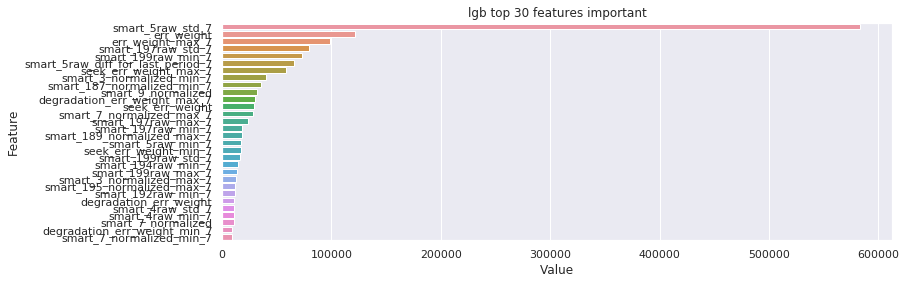

2020-03-27 17:14:51,625 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
2020-03-27 17:14:52,937 - mlpipeline.train - INFO - 原始预测为fault disk的个数：660
2020-03-27 17:14:52,938 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:

In [6]:
# eval
model_params = {
    "objective": "binary",
    "boosting": 'gbdt',  # gbdt, dart
    "learning_rate": 0.001,
    "scale_pos_weight":25,
#     "is_unbalance": True,
    "num_leaves": 64,
#     "max_bin":255,
#     'min_gain_to_split': 20,
#     "max_depth":1,
    "metric": ["auc"],
    "subsample": 0.8,
    "colsample_bytree": 0.9,
    "num_threads": 10,
    "lambda_l2": 1.2, 
    "lambda_l1": 1.2,
    "random_state": 2019,
    "min_data_in_leaf":80,
    "num_boost_round": 1000,
    "device": 'cpu',
    'boost_from_average':False
}  

params = {
    'model_params': model_params,
    'model_name': 'lgb',
    'train_fe_filename': 'train_fe_df_03_01_round_2.feather',
    'is_eval': True,
    "use_standard": False,  # whether using sklearn-standard
    'use_log': False,
    'use_cv': False,  # for cv
    'drop_cols':drop_cols,
    'use_sampling': False,
    'sampling_ratio':1,
    'train_start_date': '2018-03-01',  # when using cv, should be same as the the earliest day of cv train
    'train_end_date': '2018-05-31', # when using cv, should be same as the the latest day of cv valid
    'eval_on_model_id': None, # 1,2,None
    'train_on_model_id':None, # 1 ,2 , None
    'save_feat_important': False,
    'valid_start_date':'2018-07-01', 
    'valid_end_date': '2018-07-31',
    'train_date_list':  [['2018-02-01','2018-03-31'],['2018-03-01','2018-04-30']],  # for cv
    'val_date_list': [['2018-05-01','2018-05-31'],['2018-06-01','2018-06-30']],  # for cv
    'n_fold': 2  # for cv 
}

model, eval_df = train(**params)

2020-03-27 16:53:10,128 - mlpipeline.train - INFO - train开始
2020-03-27 16:53:10,131 - mlpipeline.train - INFO - 当前模式:train, 当前使用模型:lgb, 训练日期:2018-04-01 - 2018-05-31
2020-03-27 16:53:11,802 - mlpipeline.train - INFO - train_pipeline_lgb开始
2020-03-27 16:53:11,808 - mlpipeline.train - INFO - 连续性特征数量: 106
2020-03-27 16:53:11,809 - mlpipeline.train - INFO - 离散性特征数量: 1
2020-03-27 16:53:35,341 - mlpipeline.train - INFO - 训练集正负样本比:6342:9104994(i.e. 0.0007)
2020-03-27 16:53:35,342 - mlpipeline.train - INFO - train参数:{'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.001, 'scale_pos_weight': 25, 'num_leaves': 64, 'metric': ['auc'], 'subsample': 0.8, 'colsample_bytree': 0.6, 'num_threads': 10, 'lambda_l2': 1.5, 'lambda_l1': 1.5, 'random_state': 2019, 'min_data_in_leaf': 120, 'num_boost_round': 12, 'device': 'cpu'}
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in

[1]	training's auc: 0.769465
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.803814
[3]	training's auc: 0.815763
[4]	training's auc: 0.830881
[5]	training's auc: 0.837298
[6]	training's auc: 0.838039
[7]	training's auc: 0.846192
[8]	training's auc: 0.851587
[9]	training's auc: 0.856152
[10]	training's auc: 0.857964
[11]	training's auc: 0.866978


2020-03-27 16:54:45,167 - mlpipeline.train - INFO - eval最优轮数: 12, eval最优auc: 0.86944405470785
2020-03-27 16:54:45,169 - mlpipeline.train - INFO - 模型训练用时:0:01:10
2020-03-27 16:54:45,178 - mlpipeline.train - INFO - 特征重要性：            Value                              Feature
104  4.539615e+07                           err_weight
40   3.376561e+07                     err_weight_max_7
85   7.021854e+06                   smart_9_normalized
75   6.538600e+06    smart_5raw_diff_for_last_period_7
54   5.037460e+06                     smart_5raw_std_7
..            ...                                  ...
76   0.000000e+00   smart_12raw_diff_for_last_period_7
78   0.000000e+00  smart_194raw_diff_for_last_period_7
79   0.000000e+00  smart_197raw_diff_for_last_period_7
80   0.000000e+00  smart_198raw_diff_for_last_period_7
0    0.000000e+00                           model_type

[107 rows x 2 columns]


[12]	training's auc: 0.869444
Did not meet early stopping. Best iteration is:
[12]	training's auc: 0.869444


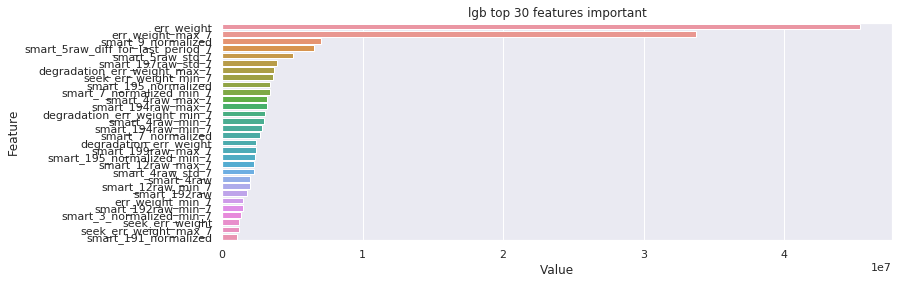

2020-03-27 16:54:46,932 - mlpipeline.train - INFO - train_pipeline_lgb已完成，共用时0:01:35
2020-03-27 16:54:47,840 - mlpipeline.train - INFO - lgb模型训练完成!模型保存至:../trained_model/lgb.model.2020-03-27T16:53:11.802595
2020-03-27 16:54:47,841 - mlpipeline.train - INFO - train已完成，共用时0:01:38


In [6]:
# train
model_params = {
    "objective": "binary",
    "boosting": 'gbdt',  # gbdt, dart
    "learning_rate": 0.001,
    "scale_pos_weight":25,
#     "is_unbalance": True,
    "num_leaves": 64,
#     "max_bin":255,
#     'min_gain_to_split': 20,
#     "max_depth":1,
    "metric": ["auc"],
    "subsample": 0.8,
    "colsample_bytree": 0.6,
    "num_threads": 10,
    "lambda_l2": 1.5, 
    "lambda_l1": 1.5,
    "random_state": 2019,
    "min_data_in_leaf":120,
    "num_boost_round": 12,
    "device": 'cpu',
#     'boost_from_average':False
}  


params = {
    'model_params': model_params,
    'model_name': 'lgb',
    'train_fe_filename': 'train_fe_df_03_01_round_2.feather',
#     'focal_loss_alpha':0.9,
#     'focal_loss_gamma':6,
    'use_sampling': False,
    'sampling_ratio':2,
    'drop_cols': drop_cols,
    'train_on_model_id':None,
    'is_eval': False,
    'use_standard': False,
    'use_log': False,
    'save_feat_important': False,
    'train_start_date': '2018-04-01',
    'train_end_date': '2018-05-31',
}

model, scaler = train(**params)

In [ ]:
# predict 
params = {'model_name': 'lgb',
          'use_standard': False,
          'use_log': False,
          'scaler':'',
            }

submission_df = predict(**params)